In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision # 데이터 셋, 아키텍처 모델, 이미지 변환 기능으로 구성되어 있는 패키지
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

# 코랩 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# GPU로 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # GPU를 사용할 수 있다면 CUDA를, 그렇지 않다면 CPU를 출력
print(device)

cuda


In [ ]:
transforms = transforms.Compose([transforms.ToTensor()]) # 이미지를 텐서로 전처리 하는 과정

train_ds = torchvision.datasets.FashionMNIST( # FashionMNIST라는 데이터를 가져옴 (ds: dataset의 약자)
    "/content/drive/MyDrive/Colab Notebooks", # 저장 경로
    download=True, # 다운로드
    train=True, # 학습 데이터
    transform=transforms # 이미지 전처리
)

test_ds = torchvision.datasets.FashionMNIST(
    "/content/drive/MyDrive/Colab Notebooks", # 저장 경로
    download=True, # 다운로드
    train=False, # 학습 데이터 X
    transform=transforms # 이미지 전처리
)

In [ ]:
batch_size = 100 # batchsize는 100

train_dl = torch.utils.data.DataLoader( # dl: data loader의 약자
    train_ds, # train_dataset에서 데이터를 가져옴
    batch_size=batch_size, # batchsize 지정
    shuffle=True # 데이터 섞음
)

test_dl = torch.utils.data.DataLoader( #
    test_ds, # test dataset에서 데이터를 가져옴
    batch_size=batch_size,
    shuffle=True
)

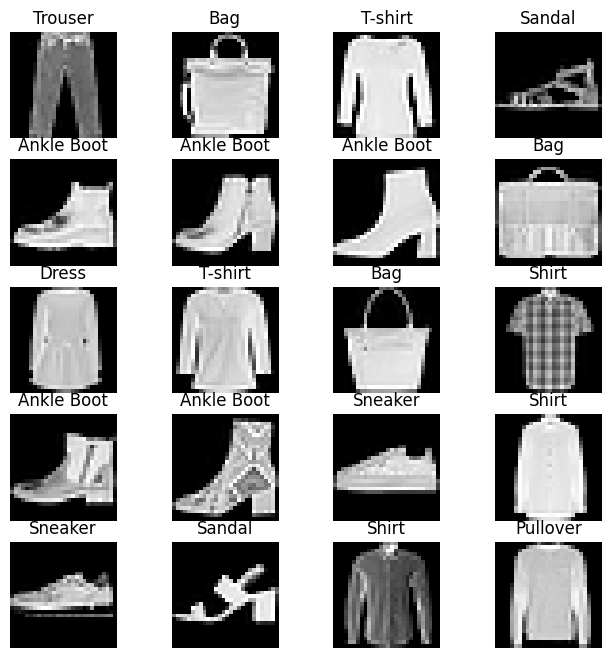

In [ ]:
labels = { # 딕셔너리 형태로 idx와 label 지정
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

fig = plt.figure(figsize=(8, 8))
cols, rows = 4, 5

for i in range(1, cols*rows+1):
    img_xy = np.random.randint(len(train_ds)) # 전체 train_ds 중에서 임의의 데이터 한 개를 정함
    img = train_ds[img_xy][0][0, :, :] # 임의의 값으로 뽑은 img_xy에서 train_ds에 img_xy번째에 해당하는 이미지를 가져옴 (이때 출력을 하면 텐서 형태로 출력)
    fig.add_subplot(rows, cols, i) # 시각화
    plt.title(labels[train_ds[img_xy][1]]) # title을 각각의 class에 맞게 지정
    plt.axis('off') # 주변 경계선 다 지움
    plt.imshow(img, cmap='gray') # 이미지를 흑백으로 출력
plt.show() # 이미지 출력

In [ ]:
class FashionDNN(nn.Module): # DNN 생성 (ConvNet 아님)
    def __init__(self): # 나는 nn.을 사용해서 구현하였음
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.relu1 = nn.ReLU()
        self.drop = nn.Dropout(0.25) # Drop 지정 1/4 확률
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu1(self.fc1(x))
        x = self.drop(x)
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
lr = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss() # 다중분류를 위한 손실함수 CrossEntropy지정
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Adam을 경사하강법으로 지정
print(model) # 모델 구조 출력

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
num_epochs = 5
count = 0

loss_list = [] # loss 값 저장
iteration_list = [] # 반복 횟수 저장
accuracy_list = [] # 정확도 저장
predictions_list = [] # 예측 값
labels_list = [] # label 리스트..?

for epoch in range(num_epochs):
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device) # images, labels를 cuda위에서 실행

        train = images.view(100, 1, 28, 28) # 텐서를 이미지 형태로 변환 (1개의 채널을 가진 28x28크기의 이미지를 100개로)
        labels = labels

        outputs = model(train) # train을 모델에 넣고 예측값을 outputs으로 정의
        loss = criterion(outputs, labels) # 예측값 outputs을 실제 labels와 비교하여 loss를 계산
        optimizer.zero_grad() # 그라디언트값 초기화 (값 누적 방지)
        loss.backward() # 역전파
        optimizer.step() # 가중치, 편향 업데이트
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_dl:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = images.view(100, 1, 28, 28)
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device) # dim=1에 대한 최댓값을 max로 지정
                predictions_list.append(predictions)
                correct += (predictions == labels).sum() # 예측값과 정답이 맞다면 sum()을 통하여 맞은 갯수 카운트
                total += len(labels)

            accuracy = correct * 100 / total # 정확도 계산
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.2614486515522003, Accuracy: 83.56999969482422%
Iteration: 1000, Loss: 0.3830000162124634, Accuracy: 84.90999603271484%
Iteration: 1500, Loss: 0.34036678075790405, Accuracy: 84.79999542236328%
Iteration: 2000, Loss: 0.3347597122192383, Accuracy: 85.32999420166016%
Iteration: 2500, Loss: 0.4910036325454712, Accuracy: 85.4000015258789%
Iteration: 3000, Loss: 0.33669012784957886, Accuracy: 86.05999755859375%


In [ ]:
# 합성곱 네트워크 생성
class FashionConvNet(nn.Module):
    def __init__(self):
        super(FashionConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(64*6*6, 600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

model = FashionConvNet()
model.to(device)

# x = torch.randn(100, 1, 28, 28).to(device)
# print(model(x).shape)

FashionConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

In [ ]:
num_epochs = 5
count = 0

loss_list = [] # loss 값 저장
iteration_list = [] # 반복 횟수 저장
accuracy_list = [] # 정확도 저장
predictions_list = [] # 예측 값
labels_list = [] # label 리스트..?

for epoch in range(num_epochs):
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device) # images, labels를 cuda위에서 실행

        train = images.view(100, 1, 28, 28) # 텐서를 이미지 형태로 변환 (1개의 채널을 가진 28x28크기의 이미지를 100개로)
        labels = labels

        outputs = model(train) # train을 모델에 넣고 예측값을 outputs으로 정의
        loss = criterion(outputs, labels) # 예측값 outputs을 실제 labels와 비교하여 loss를 계산
        optimizer.zero_grad() # 그라디언트값 초기화 (값 누적 방지)
        loss.backward() # 역전파
        optimizer.step() # 가중치, 편향 업데이트
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_dl:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = images.view(100, 1, 28, 28)
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device) # dim=1에 대한 최댓값을 max로 지정
                predictions_list.append(predictions)
                correct += (predictions == labels).sum() # 예측값과 정답이 맞다면 sum()을 통하여 맞은 갯수 카운트
                total += len(labels)

            accuracy = correct * 100 / total # 정확도 계산
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))


Iteration: 500, Loss: 2.3046655654907227, Accuracy: 10.59000015258789%
Iteration: 1000, Loss: 2.3371241092681885, Accuracy: 10.429999351501465%
Iteration: 1500, Loss: 2.3064193725585938, Accuracy: 10.59999942779541%
Iteration: 2000, Loss: 2.3272929191589355, Accuracy: 10.710000038146973%
Iteration: 2500, Loss: 2.3287601470947266, Accuracy: 10.569999694824219%
Iteration: 3000, Loss: 2.2950479984283447, Accuracy: 10.179999351501465%
